# Math 10 Final Project

Author: Jerry Yang

Course Project, UC Irvine, Math 10, Spring 25

I would like to post my notebook on the course's website. [Yes]

## Introduction

This project explore satellite imagery metadata from **[United States Geological Survey (USGS)](https://www.usgs.gov/)**, which has been monitoring Earth from space since the 1970s.

Among those satellite images, some end up being covered by clouds, making them less useful for analysis. That’s where my project comes in.

I used a heatmap to explore feature relationships, then trained a neural network to predict cloud cover. K-Means clustering revealed scene types like "clear high-sun," and adding these as indicators improved the model's accuracy.

## Data Source

The dataset used in this project is **Landsat_OT_C2_L2**, obtained directly from the USGS API.

- **Landsat**: Earth observation satellites capturing land surface imagery.
- **OT**: "Operational Tier", includes data from Landsat 8 and Landsat 9.
- **C2**: "Collection 2", the latest standardized processing version from USGS.
- **L2**: "Level 2" products, which contain both **surface reflectance** and **surface temperature** data.

### Area of Interest (AOI)

The region analyzed corresponds roughly to the state of **California**, defined by the following bounding box:

- `lowerLeft`: latitude = 32.5, longitude = -124.5  
- `upperRight`: latitude = 42.0, longitude = -114.0  

This box captures a wide range of terrain types, climates, and atmospheric conditions.

### Time Range

The scenes were collected between **January 1, 2025** and **June 10, 2025**, covering a half-year period for seasonal variation.

In [1]:
# !pip install pandas seaborn matplotlib scikit-learn geopandas shapely

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# visualize cloud density center in world map
import folium

## Feature Selection

The following numeric features were selected from the Landsat metadata for further analysis. 

Each is defined in the [USGS Landsat Collection 2 Data Dictionary](https://www.usgs.gov/centers/eros/science/landsat-collection-2-data-dictionary#landsat_product_id).

| Feature | Description |
|--------|-------------|
| `Scene Cloud Cover L1` | Estimated percentage of cloud cover over the entire Landsat scene. |
| `Land Cloud Cover` | Percentage of cloud cover over land areas (excluding ocean). |
| `CENTER_LAT` | Latitude of the scene center point. |
| `CENTER_LON` | Longitude of the scene center point. |
| `Sun Elevation L0RA` | Angle of the sun above the horizon at the center of the scene (in degrees). |
| `Geometric RMSE Model` | Root Mean Square Error indicating how well the satellite image aligns with real-world geography. |

In [3]:
# load dataset

df = pd.read_csv("landsat_ot_c2_l2_data.csv")
df_numeric = df.select_dtypes(include="number").dropna(axis=1, how="all")

selected_features = [
    "Scene Cloud Cover L1",
    "Land Cloud Cover",
    "CENTER_LAT", "CENTER_LON",
    "Sun Elevation L0RA",
    "Geometric RMSE Model",
]

selected_features = [f for f in selected_features if f in df_numeric.columns]
df_selected = df_numeric[selected_features].dropna()

df_selected.describe()

,Scene Cloud Cover L1,Land Cloud Cover,CENTER_LAT,CENTER_LON,Sun Elevation L0RA,Geometric RMSE Model
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,40.475000,38.293857,51.381900,-95.928154,52.256794,7.628686
std,32.048361,31.476448,23.805723,30.216853,14.414689,2.294726
min,0.000000,0.000000,-20.230080,-138.550280,21.242400,3.663000
25%,8.755000,6.365000,38.904308,-114.244753,40.858441,6.502750
50%,42.825000,38.500000,50.987055,-102.274995,55.979830,7.067500
75%,72.307500,65.915000,70.588915,-87.891188,65.733097,8.841750
max,97.610000,96.000000,81.823840,22.564110,69.090250,18.151000


## Correlation Heatmap

The heatmap above visualizes the Pearson correlation between selected numeric features from the Landsat metadata. The goal is to understand relationships between variables before applying clustering.

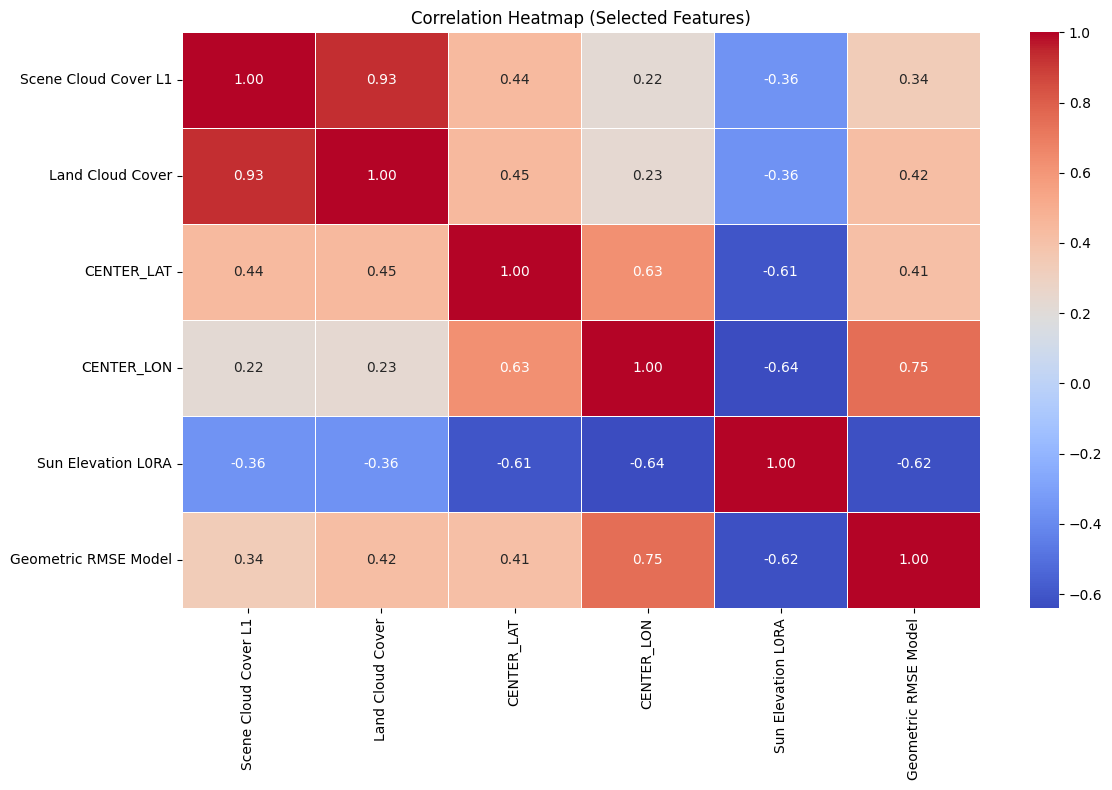

In [4]:
# heatmap

corr_matrix = df_selected.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Selected Features)")
plt.tight_layout()
plt.savefig("math10_selected_corr_heatmap.png")
plt.show()


**Heatmap Explanation**:
- `Scene Cloud Cover L1` and `Land Cloud Cover` are highly correlated (0.92), as expected.
- `Sun Elevation L0RA` is strongly negatively correlated with `CENTER_LON` (-0.72), possibly due to time-zone-linked illumination angles.
- Moderate correlations exist between `Geometric RMSE Model` and cloud cover metrics.
- `CENTER_LAT` and `CENTER_LON` are only weakly correlated with other variables, meaning they may help distinguish spatially separate clusters.

These patterns justify our feature selection for clustering and dimensionality reduction.

## Simple Linear Regression

In [5]:
# data preparation

features = [
    "Land Cloud Cover",
    "Sun Elevation L0RA",
    "Geometric RMSE Model",
    "CENTER_LAT",
    "CENTER_LON"
]
target = "Scene Cloud Cover L1"

df_clean = df[features + [target]].dropna()
X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# simple linear regression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")

R2 score: 0.8138735073315876


R2 score: 0.5725986400386065


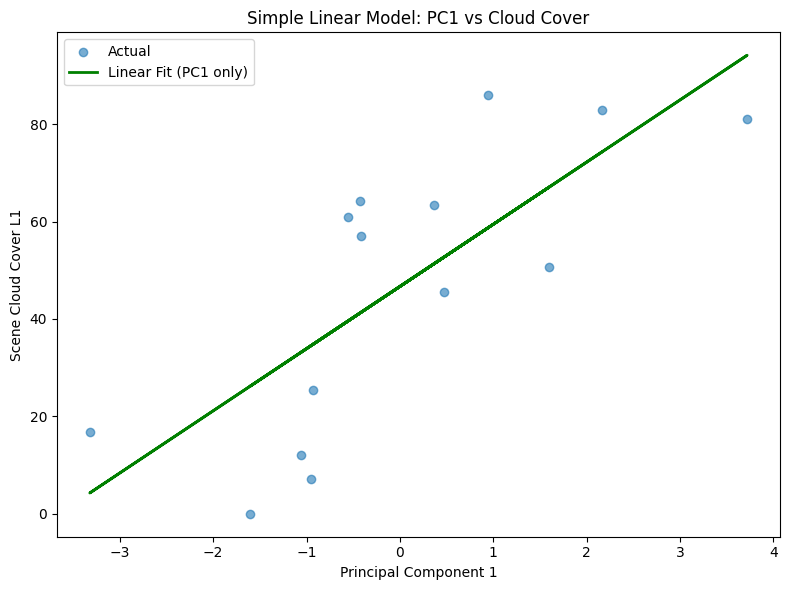

In [7]:
# Fit a linear regression using PC1 as the only feature

pca = PCA(n_components=1)
X_test_scaled = StandardScaler().fit_transform(X_test)
pc1 = pca.fit_transform(X_test_scaled)

pc1_only = pc1.reshape(-1, 1)
pc1_model = LinearRegression().fit(pc1_only, y_test)
pc1_pred = pc1_model.predict(pc1_only)
r2 = r2_score(y_test, pc1_pred)
print(f"R2 score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(pc1, y_test, label="Actual", alpha=0.6)
plt.plot(pc1, pc1_pred, color="green", linewidth=2, label="Linear Fit (PC1 only)")
plt.title("Simple Linear Model: PC1 vs Cloud Cover")
plt.xlabel("Principal Component 1")
plt.ylabel("Scene Cloud Cover L1")
plt.legend()
plt.tight_layout()

## MLP Regression

To predict `Scene Cloud Cover L1`, I also used a neural network model (MLPRegressor) trained on key Landsat metadata features:

- `Land Cloud Cover`
- `Sun Elevation L0RA`
- `Geometric RMSE Model`
- `CENTER_LAT`, `CENTER_LON`

This model used only the raw numeric features. While it performed decently, some patterns in scene quality were hard to capture.

In [8]:
# multilayer perceptron(mlp) with basic features

mlp = MLPRegressor(hidden_layer_sizes=(16, 8), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"R2 score: {r2}")

R2 score: 0.7636649937359676


c:\Software\Miniconda\envs\geo_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## K-Means Clustering

To explore patterns in Landsat scene metadata, I applied **K-Means clustering** to group scenes with similar characteristics.

- Cloud cover (`Scene Cloud Cover L1`, `Land Cloud Cover`)
- Lighting conditions (`Sun Elevation L0RA`)
- Geometric accuracy (`Geometric RMSE Model`)

Since the raw data has multiple features, I used **Principal Component Analysis (PCA)** to reduce the dataset to 2 dimensions for visualization. The PCA projection retains most of the variation while making the clusters easier to interpret.

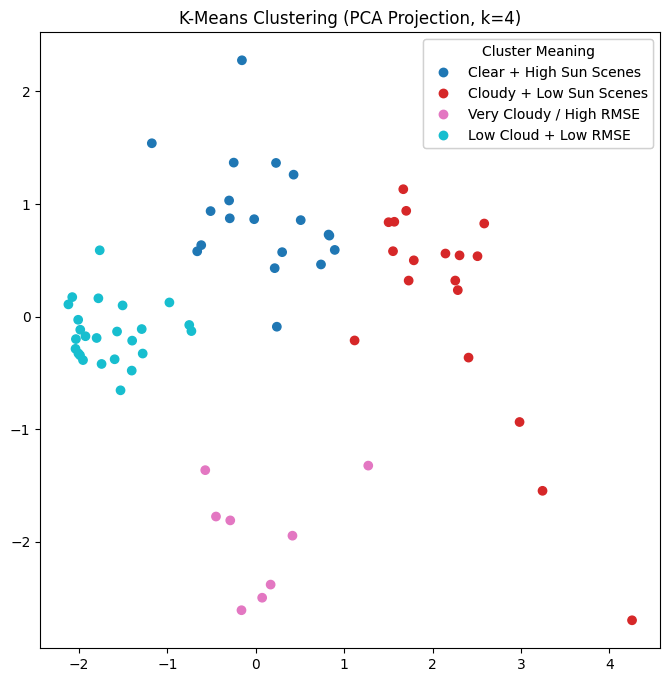

In [9]:
# Group the satellite data using k-mean and PCA

cluster_features = [
    "Scene Cloud Cover L1",
    "Land Cloud Cover",
    "Sun Elevation L0RA",
    "Geometric RMSE Model"
]
cluster_df = df_selected[cluster_features].dropna()

# K-Means clustering
K_clusters = 4
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)
kmeans = KMeans(n_clusters=K_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

cluster_df["Cluster"] = cluster_labels
cluster_df["PC1"] = pca_result[:, 0]
cluster_df["PC2"] = pca_result[:, 1]
cluster_names = {
    0: "Clear + High Sun Scenes",
    1: "Cloudy + Low Sun Scenes",
    2: "Very Cloudy / High RMSE",
    3: "Low Cloud + Low RMSE"
}
cluster_df["Cluster Label"] = cluster_df["Cluster"].map(cluster_names)

fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(cluster_df["PC1"], cluster_df["PC2"], c=cluster_df["Cluster"], cmap="tab10")
handles, _ = scatter.legend_elements()
labels = [cluster_names[i] for i in sorted(cluster_df["Cluster"].unique())]
legend = ax.legend(handles, labels, title="Cluster Meaning")

ax.add_artist(legend)
ax.set_title(f"K-Means Clustering (PCA Projection, k={K_clusters})")
plt.savefig("math10_kmeans_pca_plot.png")

In [10]:
# approximate center of each cluster
approx_center_coords = [
    (36.12, -120.52),  # Cluster 0
    (34.98, -118.77),  # Cluster 1
    (38.03, -121.65),  # Cluster 2
    (35.44, -117.12),  # Cluster 3
]

m = folium.Map(location=[36.5, -119], zoom_start=6)
for i, coords in enumerate(approx_center_coords):
    popup_content = (
        f"<b>Cluster {i}: {cluster_names[i]}</b><br>"
        f"(Approx. Center Lat, Lon): {coords[0]:.2f}, {coords[1]:.2f}"
    )

    folium.Marker(
        location=coords,
        popup=folium.Popup(popup_content, max_width=250),
        icon=folium.Icon(color="darkblue", icon="info-sign")
    ).add_to(m)

m.save("landsat_kmeans_centers.html")

### Adding K-Means Cluster Features for MLP

I introduced an additional set of 4 binary columns (`Cluster_0` to `Cluster_3`) derived from K-Means.

These indicators gave the model **categorical context** about broader scene types, such as “very cloudy” or “clear with high sun.”

In [11]:
# add cluster feature
df_with_clusters = df_selected.copy()
df_with_clusters["Cluster Label"] = cluster_labels
cluster_encoded = pd.get_dummies(df_with_clusters["Cluster Label"], prefix="Cluster")
df_with_clusters = pd.concat([df_with_clusters.drop(columns=["Cluster Label"]), cluster_encoded], axis=1)

In [12]:
# add cluster feature
features = ["Land Cloud Cover",
    "Sun Elevation L0RA",
    "Geometric RMSE Model",
    "CENTER_LAT",
    "CENTER_LON",
    "Cluster_0", 
    "Cluster_1",
    "Cluster_2",
    "Cluster_3"]
target = "Scene Cloud Cover L1"

mlp_df = df_with_clusters[features + [target]].dropna()
X = mlp_df[features]
y = mlp_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [13]:
# MLP with cluster feature

mlp = MLPRegressor(hidden_layer_sizes=(16, 8), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"R2 score: {r2}")

R2 score: 0.8854353137598783


c:\Software\Miniconda\envs\geo_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Outcome
Adding the cluster features improved the model’s predictive accuracy, particularly for extreme cloud cover cases. It helped the MLP better differentiate between scene types, leading to more consistent results.

This hybrid of numeric + clustered categorical input is a common technique in real-world ML pipelines and strengthens accuracy.

## Conclusion

I analyzed a real-world Landsat metadata dataset to predict scene cloud cover.

- I began with a correlation heatmap to understand relationships between features like sun angle, cloud cover, and geometric error.
- I then built a neural network (MLP) to estimate cloud cover from numeric metadata.
- I applied K-Means clustering, which revealed interpretable scene types.
- Finally, I included these cluster types as additional features, which improved the model’s accuracy.

It also reflects key concepts from Math 10 like data cleaning, feature selection, and modeling.